In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image

from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import random
import torch
import gc
import os
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
IMAGE_HEIGHT = 128 # RESIZED FIXED HEIGHT
IMAGE_WIDTH = 128 # RESIZED FIXED WIDTH
NUM_CLASSES = 4 # NUM OF LABELS
SEED_VALUE = 1234
#Normalise the Images
image_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
train_processed_image_annotations = "/content/drive/MyDrive/processed_image/train/_annotations.coco.json"
test_processed_image_annotations = "/content/drive/MyDrive/processed_image/test/_annotations.coco.json"
valid_processed_image_annotations = "/content/drive/MyDrive/processed_image/valid/_annotations.coco.json"

train_images = "/content/drive/MyDrive/processed_image/train/"
valid_images = "/content/drive/MyDrive/processed_image/valid/"
test_images = "/content/drive/MyDrive/processed_image/test/"

In [ ]:
# Dictionary mapping category IDs to category names
category_mapping = {
    1: 'glass',
    2: 'metal',
    3: 'paper',
    4: 'plastic'
}

def extract_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    return data['annotations'], data['images']

def process_images_with_annotations(input_dir):
    annotations_per_image = {}
    image_id_mapping = {}
    image_data_mapping = {}

    for file_name in os.listdir(input_dir):
        if file_name.lower().endswith('.json'):
            json_path = os.path.join(input_dir, file_name)
            image_annotations, image_data = extract_annotations(json_path)

            # Map image IDs to file names
            for image_info in image_data:
                image_id = image_info['id']
                file_name = image_info['file_name']
                image_id_mapping[image_id] = file_name
                image_data_mapping[image_id] = image_info

            # Replace category IDs with category names
            for annotation in image_annotations:
                category_id = annotation['category_id']
                if category_id in category_mapping:
                    annotation['category_name'] = category_mapping[category_id]

            for annotation in image_annotations:
                image_id = annotation['image_id']
                file_name = image_id_mapping[image_id]
                annotation['file_name'] = file_name

            annotations_per_image.update({file_name: image_annotations})

    return annotations_per_image

# Example usage
input_directory = r"/content/drive/MyDrive/data_preprocessing_image_classification/file_from_coco"
annotations = process_images_with_annotations(input_directory)

In [ ]:
# # Assuming you have multiple classes, set class_mode to 'categorical'
# train_data_gen = image_gen.flow_from_directory(
#     directory=train_dir,
#     shuffle=True,
#     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     class_mode="categorical")

# validation_data_gen = image_gen.flow_from_directory(
#     directory=validation_dir,
#     shuffle=True,
#     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     class_mode="categorical")


# test_data_gen = image_gen.flow_from_directory(
#     directory=test_dir,
#     shuffle=False,
#     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     class_mode="categorical")

Found 2190 images belonging to 4 classes.
Found 124 images belonging to 4 classes.
Found 66 images belonging to 4 classes.


In [ ]:
def shuffle_data(images, labels):
    # Generate random permutation of indices
    indices = np.random.permutation(len(images))
    # Shuffle images and labels using the generated indices
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]
    return shuffled_images, shuffled_labels

In [ ]:
import os
import numpy as np
from PIL import Image


def load_images_from_directory(directory, target_size=(128, 128, 3), grayscale=False):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    label_map = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            try:
                img = Image.open(img_path)

                # Convert to grayscale if specified
                if grayscale:
                    img = img.convert('L')
                    img = img.convert('RGB')  # Convert grayscale to RGB

                else:
                    # Convert grayscale images to RGB
                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                img = img.resize(target_size[:2])
                img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(label_map[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    images = np.array(images)
    labels = np.array(labels)

    return images, labels



# Define directories
train_images = r"/content/drive/MyDrive/data_preprocessing_image_classification/train/"
test_images = r"/content/drive/MyDrive/data_preprocessing_image_classification/test/"
valid_images = r"/content/drive/MyDrive/data_preprocessing_image_classification/validation/"

class_names = ['glass', 'metal','paper','plastic']

train_dir = os.path.join(train_images)
validation_dir = os.path.join(valid_images)
test_dir = os.path.join(test_images)




In [ ]:
# Load training data
train_images, train_labels = load_images_from_directory(train_dir)

# Load validation data
validation_images, validation_labels = load_images_from_directory(validation_dir)

# Load test data
test_images, test_labels = load_images_from_directory(test_dir)


# Print shapes of loaded data
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", validation_images.shape)
print("Validation labels shape:", validation_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Train images shape: (2190, 128, 128, 3)
Train labels shape: (2190,)
Validation images shape: (124, 128, 128, 3)
Validation labels shape: (124,)
Test images shape: (66, 128, 128, 3)
Test labels shape: (66,)


In [ ]:
#Colored
train_images, train_labels = shuffle_data(train_images, train_labels)

# Shuffle validation data
validation_images, validation_labels = shuffle_data(validation_images, validation_labels)

# Shuffle test data (if needed)
test_images, test_labels = shuffle_data(test_images, test_labels)

In [ ]:
# Gray-scaled:
gs_train_images, gs_train_labels = load_images_from_directory(train_dir, grayscale=True)
gs_test_images, gs_test_labels = load_images_from_directory(test_dir, grayscale=True)
gs_validation_images, gs_validation_labels = load_images_from_directory(validation_dir, grayscale=True)

In [ ]:
gs_train_images, gs_train_labels = shuffle_data(gs_train_images, gs_train_labels)

# Shuffle validation data
gs_validation_images, gs_validation_labels = shuffle_data(gs_validation_images, gs_validation_labels)

# Shuffle test data (if needed)
gs_test_images, gs_test_labels = shuffle_data(gs_test_images, gs_test_labels)

# ResNet Self-Trained

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform



def identity_block_sequential(X,          # Input tensor for the identity block.
                    f,          # Integer, specifying the shape of the middle CONV's window for the main path.
                    filters,    # List of 3 integers, defining the number of filters in the CONV layers of the main path.
                    stage,      # Integer, used to name the layers, depending on their position in the network.
                    block       # String, used to name the layers, depending on their position in the network.
                    ):
    """
    Implementation of the identity block

    Parameters:
    X (tensor): Input tensor for the identity block.
    f (int): Integer, specifying the shape of the middle CONV's window for the main path.
    filters (list): List of 3 integers, defining the number of filters in the CONV layers of the main path.
    stage (int): Integer, used to name the layers, depending on their position in the network.
    block (str): String, used to name the layers, depending on their position in the network.

    Returns:
    X (tensor): Output tensor of the identity block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X
    weight_decay = 1e-4

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=123))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=123))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=123))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def convolutional_block_sequential(X,           # Input tensor for the convolutional block.
                        f,           # Integer, specifying the shape of the middle CONV's window for the main path.
                        filters,     # List of 3 integers, defining the number of filters in the CONV layers of the main path.
                        stage,       # Integer, used to name the layers, depending on their position in the network.
                        block,       # String, used to name the layers, depending on their position in the network.
                        s=2          # Integer, specifying the stride to be used.
                        ):
    """
    Implementation of the convolutional block

    Parameters:
      X (tensor): Input tensor for the convolutional block.
      f (int): Integer, specifying the shape of the middle CONV's window for the main path.
      filters (list): List of 3 integers, defining the number of filters in the CONV layers of the main path.
      stage (int): Integer, used to name the layers, depending on their position in the network.
      block (str): String, used to name the layers, depending on their position in the network.
      s (int): Integer, specifying the stride to be used. Defaults to 2.

    Returns:
      X (tensor): Output tensor of the convolutional block.
    """

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X
    weight_decay = 1e-4

    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a', padding='valid', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=regularizers.l2(weight_decay))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides=(1, 1), name=conv_name_base + '2b', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=regularizers.l2(weight_decay))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c', padding='valid', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=regularizers.l2(weight_decay))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1', padding='valid', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=regularizers.l2(weight_decay))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def ResNet50_sequential(input_shape=(64, 64, 3), classes=4):
    X_input = Input(input_shape)

    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=regularizers.l2(1e-4))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block_sequential(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block_sequential(X, f=3, filters=[64, 64, 256], stage=2, block='b')
    X = identity_block_sequential(X, f=3, filters=[64, 64, 256], stage=2, block='c')

    X = convolutional_block_sequential(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block_sequential(X, f=3, filters=[128, 128, 512], stage=3, block='b')
    X = identity_block_sequential(X, f=3, filters=[128, 128, 512], stage=3, block='c')
    X = identity_block_sequential(X, f=3, filters=[128, 128, 512], stage=3, block='d')

    X = convolutional_block_sequential(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block_sequential(X, f=3, filters=[256, 256, 1024], stage=4, block='b')
    X = identity_block_sequential(X, f=3, filters=[256, 256, 1024], stage=4, block='c')
    X = identity_block_sequential(X, f=3, filters=[256, 256, 1024], stage=4, block='d')
    X = identity_block_sequential(X, f=3, filters=[256, 256, 1024], stage=4, block='e')
    X = identity_block_sequential(X, f=3, filters=[256, 256, 1024], stage=4, block='f')

    X = convolutional_block_sequential(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block_sequential(X, f=3, filters=[512, 512, 2048], stage=5, block='b')
    X = identity_block_sequential(X, f=3, filters=[512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50_sequential')
    return model

model = ResNet50_sequential(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), classes=4)
# Define the learning rate
learning_rate = 1e-6
# Compile the model with the specified optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# # # Freezing some layers
# for layer in model.layers:
#     if 'conv5' in layer.name or 'fc4' in layer.name:  # Modify this condition based on your layer names
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [ ]:
model.summary()

Model: "ResNet50_sequential"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 64, 64, 64)           9472      ['input_8[0][0]']             
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 activation_343 (Activation  (None, 64, 64, 64)           0         ['bn_conv1[0

In [ ]:
batch_size = 16
epochs = 200

history = model.fit(
    train_images,
    train_labels,
    validation_data=(validation_images, validation_labels),
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,  # Shuffle the training data
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-6,
        patience=10
    )]
)

Epoch 1/200
137/137 [==============================] - 50s 96ms/step - loss: 2.4026 - accuracy: 0.2895 - val_loss: 2.0753 - val_accuracy: 0.2984
Epoch 2/200
137/137 [==============================] - 11s 78ms/step - loss: 2.1867 - accuracy: 0.2886 - val_loss: 2.1692 - val_accuracy: 0.2984
Epoch 3/200
137/137 [==============================] - 11s 80ms/step - loss: 2.1291 - accuracy: 0.2936 - val_loss: 2.0751 - val_accuracy: 0.2984
Epoch 4/200
137/137 [==============================] - 11s 81ms/step - loss: 2.1119 - accuracy: 0.3183 - val_loss: 2.1084 - val_accuracy: 0.2661
Epoch 5/200
137/137 [==============================] - 12s 90ms/step - loss: 2.0679 - accuracy: 0.3219 - val_loss: 2.0529 - val_accuracy: 0.3065
Epoch 6/200
137/137 [==============================] - 11s 81ms/step - loss: 2.0455 - accuracy: 0.3475 - val_loss: 2.0493 - val_accuracy: 0.3145
Epoch 7/200
137/137 [==============================] - 13s 93ms/step - loss: 2.0076 - accuracy: 0.3584 - val_loss: 2.0887 - val_ac

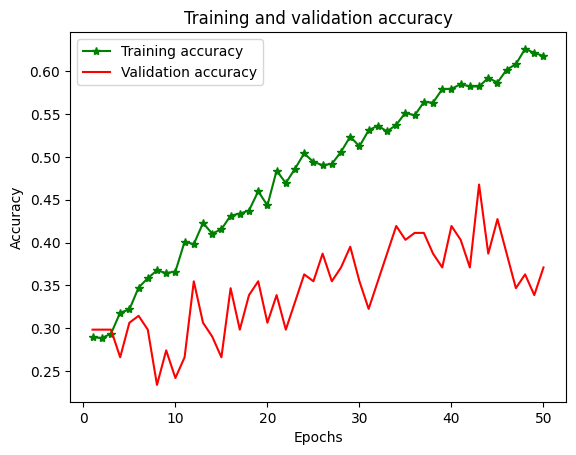

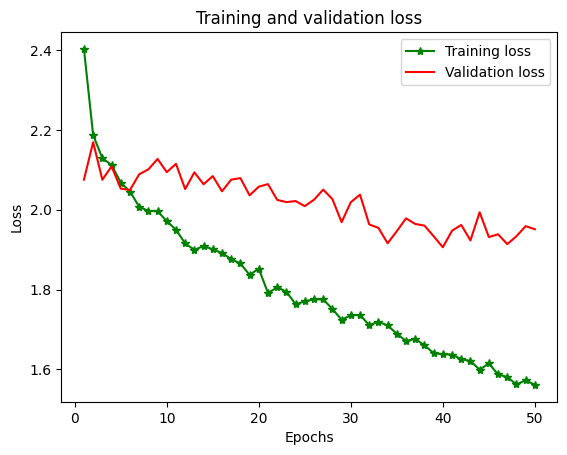

In [ ]:
import matplotlib.pyplot as plt


train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
# prompt: give me the code to get the classification report of predict vs test

import numpy as np
from sklearn.metrics import classification_report

results = model.predict(test_images)
# Get the predicted labels
predicted_labels = np.argmax(results, axis=1)

# Generate the classification report
report = classification_report(test_labels, predicted_labels)

# Print the report
print(report)


3/3 [==============================] - 4s 431ms/step
              precision    recall  f1-score   support

           0       0.50      0.54      0.52        13
           1       0.31      0.31      0.31        16
           2       0.36      0.29      0.32        17
           3       0.50      0.55      0.52        20

    accuracy                           0.42        66
   macro avg       0.42      0.42      0.42        66
weighted avg       0.42      0.42      0.42        66



# CNN Self Trained

In [ ]:
cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(4, activation='softmax')
])

learning_rate = 1e-4

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 16, 16, 32)       

In [ ]:
batch_size = 8
epochs = 50

history = cnn_model.fit(
    train_images,
    train_labels,
    validation_data=(validation_images, validation_labels),
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,  # Shuffle the training data

)

Epoch 1/50
274/274 [==============================] - 4s 9ms/step - loss: 1.3443 - accuracy: 0.3297 - val_loss: 1.2736 - val_accuracy: 0.3629
Epoch 2/50
274/274 [==============================] - 3s 11ms/step - loss: 1.2339 - accuracy: 0.4443 - val_loss: 1.2289 - val_accuracy: 0.4194
Epoch 3/50
274/274 [==============================] - 4s 14ms/step - loss: 1.1670 - accuracy: 0.5142 - val_loss: 1.1910 - val_accuracy: 0.4274
Epoch 4/50
274/274 [==============================] - 3s 9ms/step - loss: 1.1003 - accuracy: 0.5452 - val_loss: 1.1666 - val_accuracy: 0.5323
Epoch 5/50
274/274 [==============================] - 2s 7ms/step - loss: 1.0418 - accuracy: 0.5767 - val_loss: 1.1866 - val_accuracy: 0.4919
Epoch 6/50
274/274 [==============================] - 2s 7ms/step - loss: 0.9668 - accuracy: 0.6196 - val_loss: 1.1546 - val_accuracy: 0.5403
Epoch 7/50
274/274 [==============================] - 2s 7ms/step - loss: 0.9044 - accuracy: 0.6489 - val_loss: 1.2144 - val_accuracy: 0.4597
Epoc

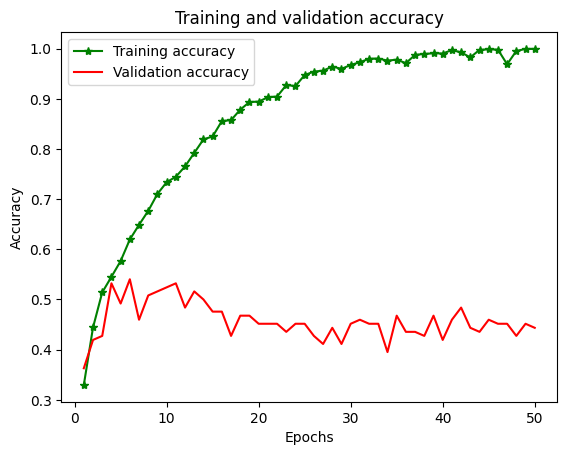

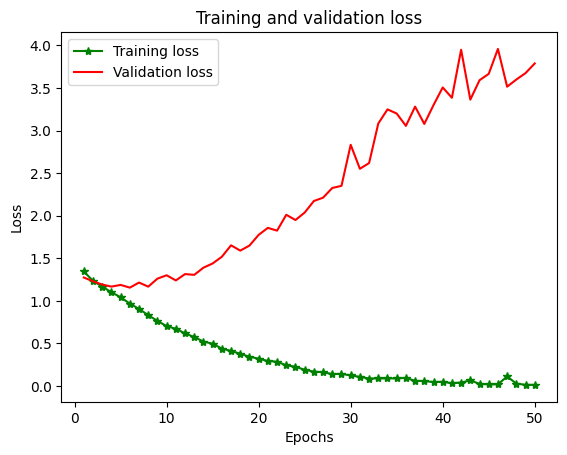

In [ ]:
import matplotlib.pyplot as plt


train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
# prompt: give me the code to get the classification report of predict vs test

import numpy as np
from sklearn.metrics import classification_report

results = cnn_model.predict(test_images)
# Get the predicted labels
predicted_labels = np.argmax(results, axis=1)

# Generate the classification report
report = classification_report(test_labels, predicted_labels)

# Print the report
print(report)


3/3 [==============================] - 1s 109ms/step
              precision    recall  f1-score   support

           0       0.33      0.46      0.39        13
           1       0.38      0.38      0.38        16
           2       0.64      0.53      0.58        17
           3       0.67      0.60      0.63        20

    accuracy                           0.50        66
   macro avg       0.50      0.49      0.49        66
weighted avg       0.52      0.50      0.51        66



In [ ]:
model.save('cnn_self_trained.hd5')

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/cnn_self_trained.hd5")

In [ ]:
loaded_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 zero_padding2d_23 (ZeroPad  (None, 134, 134, 1)          0         ['input_24[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1 (Conv2D)              (None, 64, 64, 64)           3200      ['zero_padding2d_23[0][0]']   
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1[0][0]']        

# ResNet Pretrained (Requires Colored Data)

# RGB Res Net

In [ ]:
"""
  Use Pretrained ResNet Model
"""
model = tf.keras.Sequential(
    [
        tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False,
                                                input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,
                                                             3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation="softmax")
    ]
)

learning_rate = 1e-6
# Compile the model with the specified optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Freezing some layers
for layer in model.layers:
    layer.trainable = False


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 131076    
                                                                 
Total params: 23718788 (90.48 MB)
Trainable params: 23665668 (90.28 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
batch_size = 16
epochs = 200

history = model.fit(
    train_images,
    train_labels,
    validation_data=(validation_images, validation_labels),
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,  # Shuffle the training data
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-6,
        patience=10
    )]
)

Epoch 1/200
137/137 [==============================] - 66s 135ms/step - loss: 2.2561 - accuracy: 0.2735 - val_loss: 5.9429 - val_accuracy: 0.2984
Epoch 2/200
137/137 [==============================] - 11s 80ms/step - loss: 1.7209 - accuracy: 0.3913 - val_loss: 4.6652 - val_accuracy: 0.3226
Epoch 3/200
137/137 [==============================] - 11s 80ms/step - loss: 1.4271 - accuracy: 0.4616 - val_loss: 2.8026 - val_accuracy: 0.2984
Epoch 4/200
137/137 [==============================] - 11s 80ms/step - loss: 1.1701 - accuracy: 0.5429 - val_loss: 2.1385 - val_accuracy: 0.2984
Epoch 5/200
137/137 [==============================] - 12s 87ms/step - loss: 0.9914 - accuracy: 0.6178 - val_loss: 2.0577 - val_accuracy: 0.3145
Epoch 6/200
137/137 [==============================] - 11s 82ms/step - loss: 0.8254 - accuracy: 0.6735 - val_loss: 1.9025 - val_accuracy: 0.3710
Epoch 7/200
137/137 [==============================] - 11s 83ms/step - loss: 0.7278 - accuracy: 0.7297 - val_loss: 1.7514 - val_a

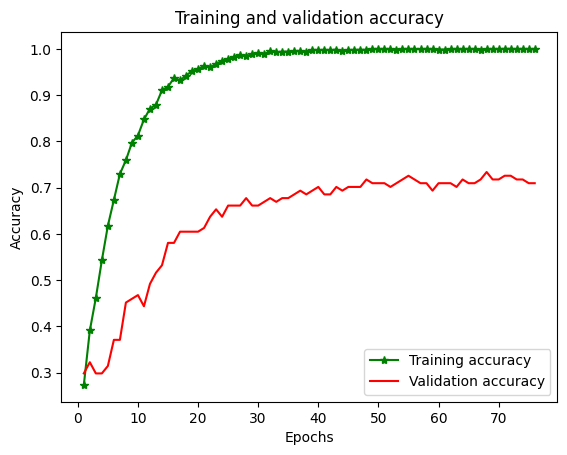

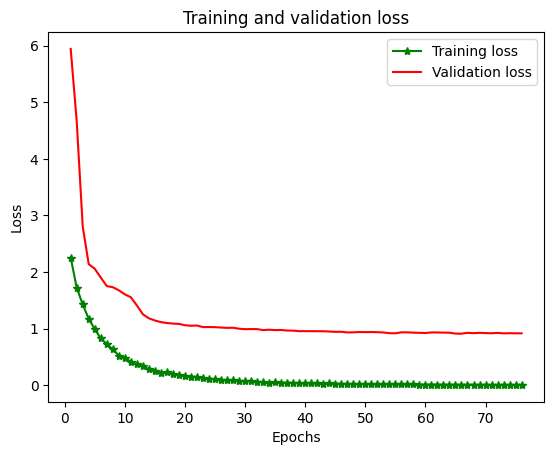

In [ ]:
import matplotlib.pyplot as plt


train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
# prompt: give me the code to get the classification report of predict vs test

import numpy as np
from sklearn.metrics import classification_report

results = model.predict(test_images)
# Get the predicted labels
predicted_labels = np.argmax(results, axis=1)

# Generate the classification report
report = classification_report(test_labels, predicted_labels)

# Print the report
print(report)


3/3 [==============================] - 7s 358ms/step
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.77      0.62      0.69        16
           2       0.68      0.76      0.72        17
           3       0.70      0.70      0.70        20

    accuracy                           0.70        66
   macro avg       0.70      0.70      0.69        66
weighted avg       0.70      0.70      0.70        66



# GrayScale ResNet

In [ ]:
"""
  Use Pretrained ResNet Model
"""
model = tf.keras.Sequential(
    [
        tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False,
                                                input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,
                                                             3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation="softmax")
    ]
)

learning_rate = 1e-6
# Compile the model with the specified optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 4)                 131076    
                                                                 
Total params: 23718788 (90.48 MB)
Trainable params: 23665668 (90.28 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
batch_size = 16
epochs = 200

history = model.fit(
    gs_train_images,
    gs_train_labels,
    validation_data=(gs_validation_images, gs_validation_labels),
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,  # Shuffle the training data
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-6,
        patience=10
    )]
)

Epoch 1/200
137/137 [==============================] - 52s 92ms/step - loss: 1.9786 - accuracy: 0.3297 - val_loss: 2.1482 - val_accuracy: 0.2500
Epoch 2/200
137/137 [==============================] - 11s 83ms/step - loss: 1.5747 - accuracy: 0.4260 - val_loss: 3.8401 - val_accuracy: 0.3065
Epoch 3/200
137/137 [==============================] - 11s 82ms/step - loss: 1.2994 - accuracy: 0.4904 - val_loss: 3.1260 - val_accuracy: 0.3226
Epoch 4/200
137/137 [==============================] - 11s 81ms/step - loss: 1.0349 - accuracy: 0.5877 - val_loss: 2.6497 - val_accuracy: 0.2742
Epoch 5/200
137/137 [==============================] - 11s 80ms/step - loss: 0.8716 - accuracy: 0.6511 - val_loss: 2.3610 - val_accuracy: 0.2742
Epoch 6/200
137/137 [==============================] - 11s 82ms/step - loss: 0.7115 - accuracy: 0.7228 - val_loss: 2.0292 - val_accuracy: 0.3065
Epoch 7/200
137/137 [==============================] - 11s 82ms/step - loss: 0.6334 - accuracy: 0.7534 - val_loss: 1.9112 - val_ac

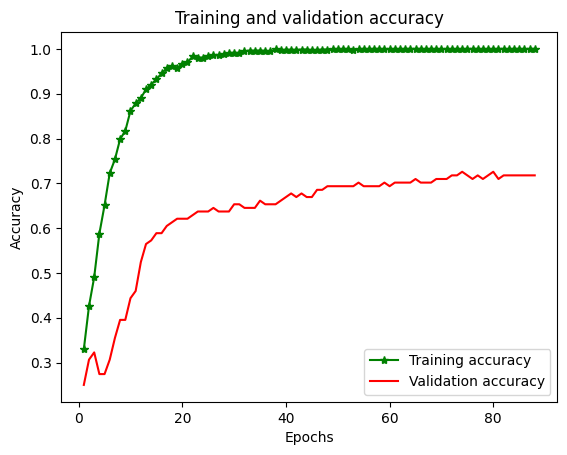

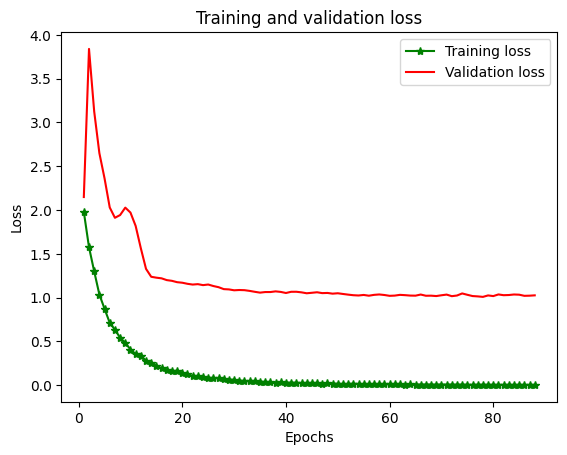

In [ ]:
import matplotlib.pyplot as plt


train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
# prompt: give me the code to get the classification report of predict vs test

import numpy as np
from sklearn.metrics import classification_report

results = model.predict(gs_test_images)
# Get the predicted labels
predicted_labels = np.argmax(results, axis=1)

# Generate the classification report
report = classification_report(gs_test_labels, predicted_labels)

# Print the report
print(report)


3/3 [==============================] - 0s 52ms/step
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.61      0.69      0.65        16
           2       0.67      0.59      0.62        17
           3       0.68      0.65      0.67        20

    accuracy                           0.68        66
   macro avg       0.69      0.69      0.69        66
weighted avg       0.68      0.68      0.68        66



# Kaggle Dataset ResNet

## Download Kaggle

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the Kaggle API
api = KaggleApi()

# Authenticate using your Kaggle API credentials
api.authenticate()

# Specify the dataset you want to download (replace 'dataset-name' with the actual dataset name)
dataset_name = 'farzadnekouei/trash-type-image-dataset'

# Download the dataset
api.dataset_download_files(dataset_name, path='.', unzip=True)

In [ ]:
#!rm -rf TrashType_Image_Dataset/cardboard
# !rm -rf TrashType_Image_Dataset/trash

In [ ]:
images_dir = r"/content/TrashType_Image_Dataset"

In [ ]:
images, labels = load_images_from_directory(images_dir)

In [ ]:
images, labels = shuffle_data(images, labels)

In [ ]:
gs_images, gs_labels = load_images_from_directory(images_dir, grayscale=True)

In [ ]:
gs_images, gs_labels = shuffle_data(gs_images, gs_labels)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=SEED_VALUE)
# Further split the train set into train and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED_VALUE)

## Pretrained RGB Kaggle

In [ ]:
"""
  Use Pretrained ResNet Model
"""
model = tf.keras.Sequential(
    [
        tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False,
                                                input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,
                                                             3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation="softmax")
    ]
)

learning_rate = 1e-6
# Compile the model with the specified optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
batch_size = 16
epochs = 200

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,  # Shuffle the training data
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-6,
        patience=10
    )]
)

Epoch 1/200
100/100 [==============================] - 59s 136ms/step - loss: 2.4623 - accuracy: 0.2700 - val_loss: 2.2459 - val_accuracy: 0.2764
Epoch 2/200
100/100 [==============================] - 8s 85ms/step - loss: 2.0699 - accuracy: 0.3128 - val_loss: 3.8608 - val_accuracy: 0.2814
Epoch 3/200
100/100 [==============================] - 8s 81ms/step - loss: 1.7882 - accuracy: 0.3499 - val_loss: 4.1799 - val_accuracy: 0.2613
Epoch 4/200
100/100 [==============================] - 8s 85ms/step - loss: 1.5359 - accuracy: 0.4361 - val_loss: 3.8671 - val_accuracy: 0.2211
Epoch 5/200
100/100 [==============================] - 8s 82ms/step - loss: 1.4030 - accuracy: 0.4758 - val_loss: 3.3696 - val_accuracy: 0.2412
Epoch 6/200
100/100 [==============================] - 8s 82ms/step - loss: 1.2387 - accuracy: 0.5324 - val_loss: 2.8923 - val_accuracy: 0.2513
Epoch 7/200
100/100 [==============================] - 8s 85ms/step - loss: 1.0802 - accuracy: 0.5796 - val_loss: 2.3941 - val_accurac

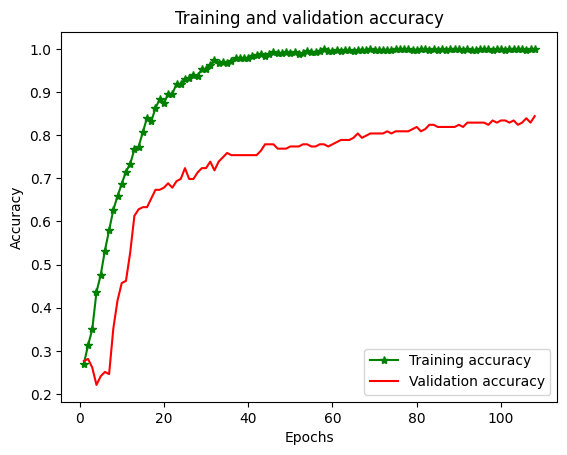

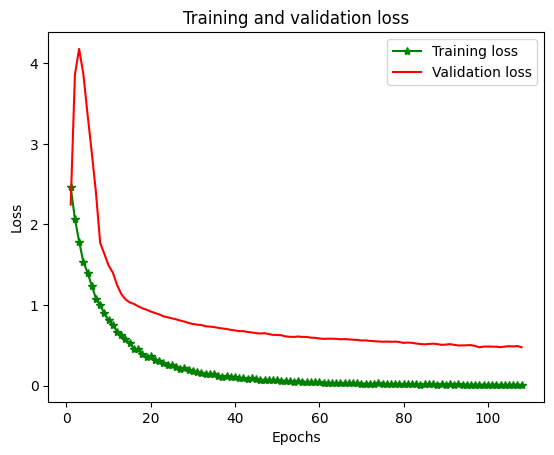

In [ ]:
import matplotlib.pyplot as plt


train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
# prompt: give me the code to get the classification report of predict vs test

import numpy as np
from sklearn.metrics import classification_report

results = model.predict(X_test)
# Get the predicted labels
predicted_labels = np.argmax(results, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_labels)

# Print the report
print(report)


7/7 [==============================] - 0s 58ms/step
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        48
           1       0.85      0.71      0.77        41
           2       0.83      0.89      0.86        61
           3       0.72      0.78      0.75        49

    accuracy                           0.79       199
   macro avg       0.80      0.78      0.79       199
weighted avg       0.80      0.79      0.79       199



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gs_images, gs_labels, test_size=0.2, random_state=SEED_VALUE)
# Further split the train set into train and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED_VALUE)

## Pretrained Kaggle Gray-scale

In [ ]:
"""
  Use Pretrained ResNet Model
"""
model = tf.keras.Sequential(
    [
        tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False,
                                                input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,
                                                             3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation="softmax")
    ]
)

learning_rate = 1e-6
# Compile the model with the specified optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
batch_size = 16
epochs = 200

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,  # Shuffle the training data
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-6,
        patience=10
    )]
)

Epoch 1/200
100/100 [==============================] - 58s 97ms/step - loss: 2.1945 - accuracy: 0.2889 - val_loss: 2.3506 - val_accuracy: 0.2261
Epoch 2/200
100/100 [==============================] - 8s 85ms/step - loss: 1.8999 - accuracy: 0.3726 - val_loss: 2.3787 - val_accuracy: 0.1608
Epoch 3/200
100/100 [==============================] - 8s 82ms/step - loss: 1.6109 - accuracy: 0.4254 - val_loss: 3.1985 - val_accuracy: 0.1709
Epoch 4/200
100/100 [==============================] - 8s 85ms/step - loss: 1.4237 - accuracy: 0.4821 - val_loss: 3.2898 - val_accuracy: 0.1658
Epoch 5/200
100/100 [==============================] - 8s 84ms/step - loss: 1.2870 - accuracy: 0.5330 - val_loss: 3.5577 - val_accuracy: 0.1709
Epoch 6/200
100/100 [==============================] - 8s 81ms/step - loss: 1.1105 - accuracy: 0.5714 - val_loss: 3.1091 - val_accuracy: 0.2613
Epoch 7/200
100/100 [==============================] - 8s 85ms/step - loss: 0.9724 - accuracy: 0.6237 - val_loss: 2.2444 - val_accuracy

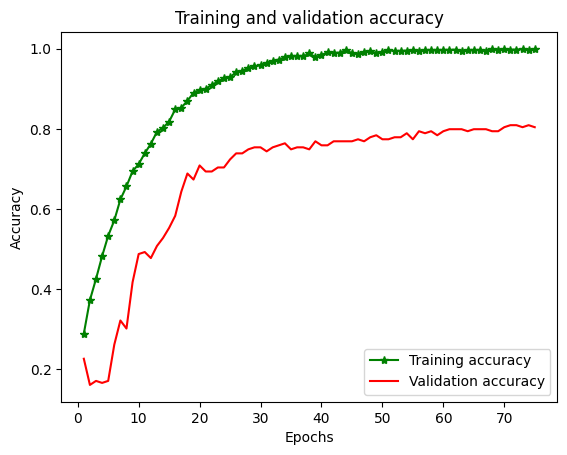

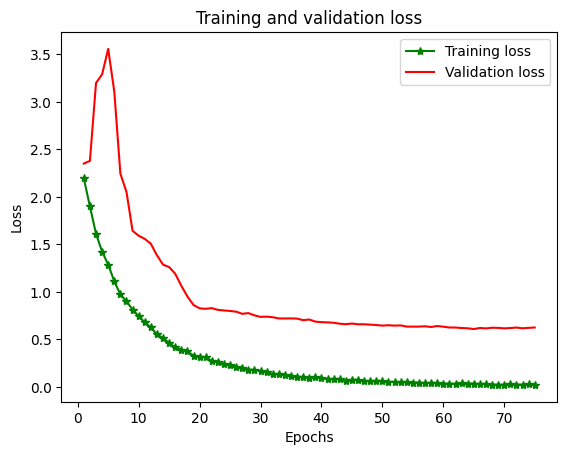

In [ ]:
import matplotlib.pyplot as plt


train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
# prompt: give me the code to get the classification report of predict vs test

import numpy as np
from sklearn.metrics import classification_report

results = model.predict(X_test)
# Get the predicted labels
predicted_labels = np.argmax(results, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_labels)

# Print the report
print(report)


7/7 [==============================] - 1s 48ms/step
              precision    recall  f1-score   support

           0       0.62      0.84      0.71        37
           1       0.86      0.75      0.80        56
           2       0.87      0.95      0.90        55
           3       0.80      0.63      0.70        51

    accuracy                           0.79       199
   macro avg       0.79      0.79      0.78       199
weighted avg       0.80      0.79      0.79       199



# VGG16

In [ ]:
import matplotlib.pyplot as plt


train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
# Define the pre-trained VGG16 model with ImageNet weights
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False,
                                         input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Create a Sequential model by adding layers on top of the VGG16 base model
model = tf.keras.Sequential([
    base_model,  # Add the VGG16 base model
    tf.keras.layers.Flatten(),  # Flatten layer to convert 2D output to 1D
    tf.keras.layers.Dense(4, activation='softmax')  # Output dense layer with softmax activation
])

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
learning_rate = 1e-6
# Compile the model with the specified optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 32772     
                                                                 
Total params: 14747460 (56.26 MB)
Trainable params: 14747460 (56.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
batch_size = 16
epochs = 200

history = model.fit(
    train_images,
    train_labels,
    validation_data=(validation_images, validation_labels),
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,  # Shuffle the training data
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-6,
        patience=10
    )]
)

Epoch 1/200
137/137 [==============================] - 31s 143ms/step - loss: 1.4831 - accuracy: 0.3662 - val_loss: 1.2649 - val_accuracy: 0.4758
Epoch 2/200
137/137 [==============================] - 12s 87ms/step - loss: 1.1168 - accuracy: 0.5498 - val_loss: 1.0519 - val_accuracy: 0.6290
Epoch 3/200
137/137 [==============================] - 12s 86ms/step - loss: 0.9111 - accuracy: 0.6731 - val_loss: 0.9273 - val_accuracy: 0.6532
Epoch 4/200
137/137 [==============================] - 12s 84ms/step - loss: 0.7355 - accuracy: 0.7438 - val_loss: 0.8527 - val_accuracy: 0.6613
Epoch 5/200
137/137 [==============================] - 11s 84ms/step - loss: 0.5793 - accuracy: 0.8091 - val_loss: 0.8190 - val_accuracy: 0.7177
Epoch 6/200
137/137 [==============================] - 11s 84ms/step - loss: 0.4487 - accuracy: 0.8580 - val_loss: 0.8029 - val_accuracy: 0.7258
Epoch 7/200
137/137 [==============================] - 12s 85ms/step - loss: 0.3389 - accuracy: 0.9032 - val_loss: 0.8090 - val_a

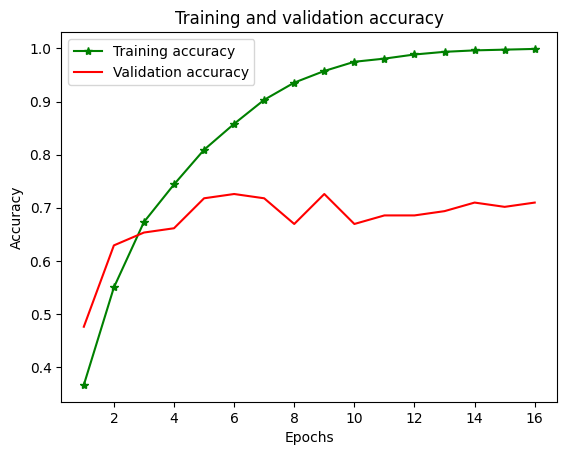

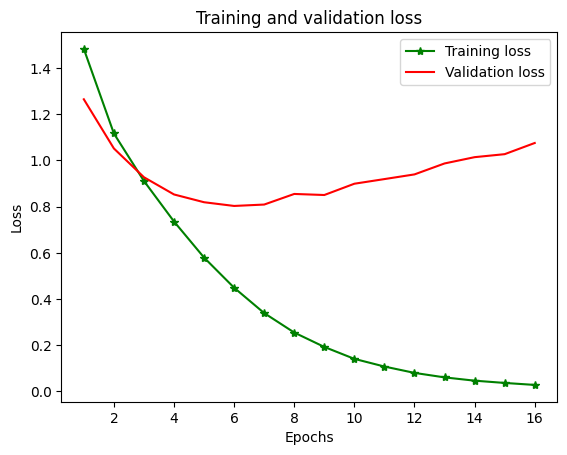

In [ ]:
import matplotlib.pyplot as plt


train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
# prompt: give me the code to get the classification report of predict vs test

import numpy as np
from sklearn.metrics import classification_report

results = model.predict(test_images)
# Get the predicted labels
predicted_labels = np.argmax(results, axis=1)

# Generate the classification report
report = classification_report(test_labels, predicted_labels)

# Print the report
print(report)


3/3 [==============================] - 4s 478ms/step
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       0.62      0.81      0.70        16
           2       0.69      0.65      0.67        17
           3       0.71      0.60      0.65        20

    accuracy                           0.67        66
   macro avg       0.67      0.67      0.66        66
weighted avg       0.67      0.67      0.66        66



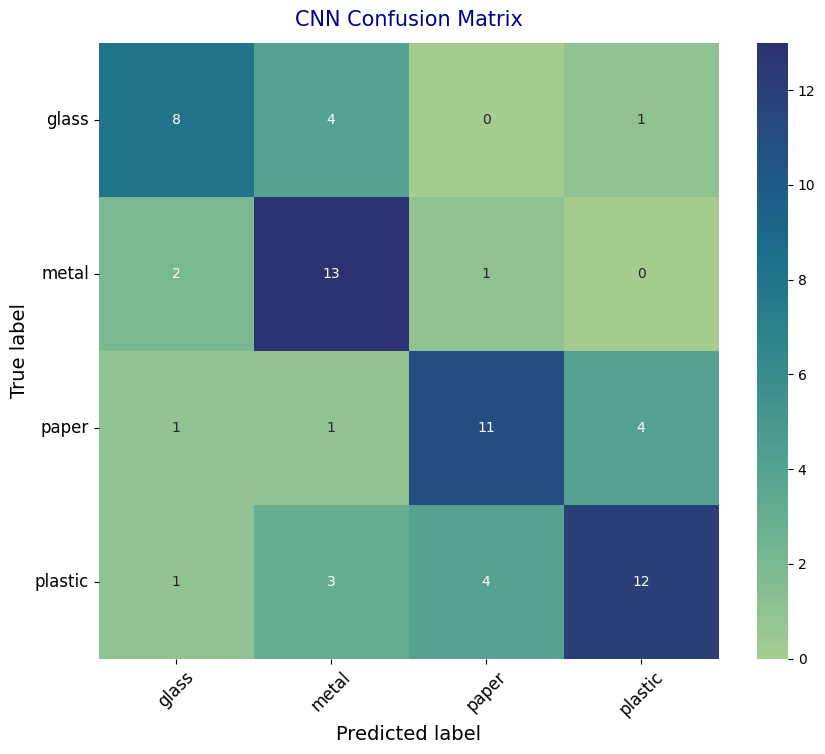

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_labels, predicted_labels)
class_labels = ['glass', 'metal', 'paper', 'plastic']
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=class_labels, yticklabels=class_labels)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, fontsize=12)
plt.title('CNN Confusion Matrix', fontsize=15, pad=12, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
test_df = get_pd_data(test_processed_image_annotations)

In [ ]:
X_test = np.array([get_pixels_colored(test_images, x, IMAGE_HEIGHT, IMAGE_WIDTH) for x in test_df["file_name"]], dtype=np.float32)
y_test = np.array(test_df.category_id - 1)

In [ ]:
results = model.predict(X_test)

4/4 [==============================] - 12s 3s/step


In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 10s 2s/step - loss: 18676228.0000 - accuracy: 0.5360


[18676228.0, 0.5360000133514404]

In [ ]:
np.argmax(results,axis = 1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
# prompt: give me the code to get the classification report of predict vs test

import numpy as np
from sklearn.metrics import classification_report

# Get the predicted labels
predicted_labels = np.argmax(results, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_labels)

# Print the report
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        30
           3       0.54      1.00      0.70        67

    accuracy                           0.54       125
   macro avg       0.13      0.25      0.17       125
weighted avg       0.29      0.54      0.37       125



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
gc.collect()

253912